# Inference Guide


## Overview

We construct a promptable [ImageDecoder](../tokenize_anything/modeling/image_decoder.py) by adding a semantic token to each mask token. The semantic token is pre-trained to align EVACLIP-5B on SA-1B masks in a concept space merged from common datasets, thus it can be used for classification on a dataset-specific concept vocabulary. The semantic token is also used to prompt a [TextDecoder](../tokenize_anything/modeling/text_decoder.py) fine-tuning the 3.8M Visual Genome region captions. Therefore, **TAP** can conduct comprehensive understanding of arbitrary image regions.


## Setup

Necessary imports and helper functions for displaying points, boxes, and masks.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

np.random.seed(1234)
inference_mode = torch.inference_mode()
inference_mode.__enter__()

def show_mask(mask, ax):
    color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    ax.imshow(mask.reshape(mask.shape[-2:] + (1,)) * color.reshape(1, 1, -1))

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)


## Build

First, build the default ``TAP-L`` model.


In [2]:
import sys
sys.path.append("..")
from tokenize_anything import model_registry, TapPredictor, TapAutomaticMaskGenerator

model_type = "tap_vit_l"
checkpoint = "../checkpoints/tap/tap_vit_l_03f8ec.pkl"
tap = model_registry[model_type](checkpoint=checkpoint).cuda()
tap_predictor = TapPredictor(tap)
mask_generator = TapAutomaticMaskGenerator(tap)

To predict concepts and generate captions, setup [ConceptProjector](../tokenize_anything/modeling/concept_projector.py) and [TextDecoder](../tokenize_anything/modeling/text_decoder.py).

In [3]:
# concept_weights = "../checkpoints/tap/merged_2560.pkl"
# model.concept_projector.reset_weights(concept_weights)
tap.text_decoder.reset_cache(max_batch_size=1024)


## Preprocessing

Next, load and show the ``fairytale`` image.

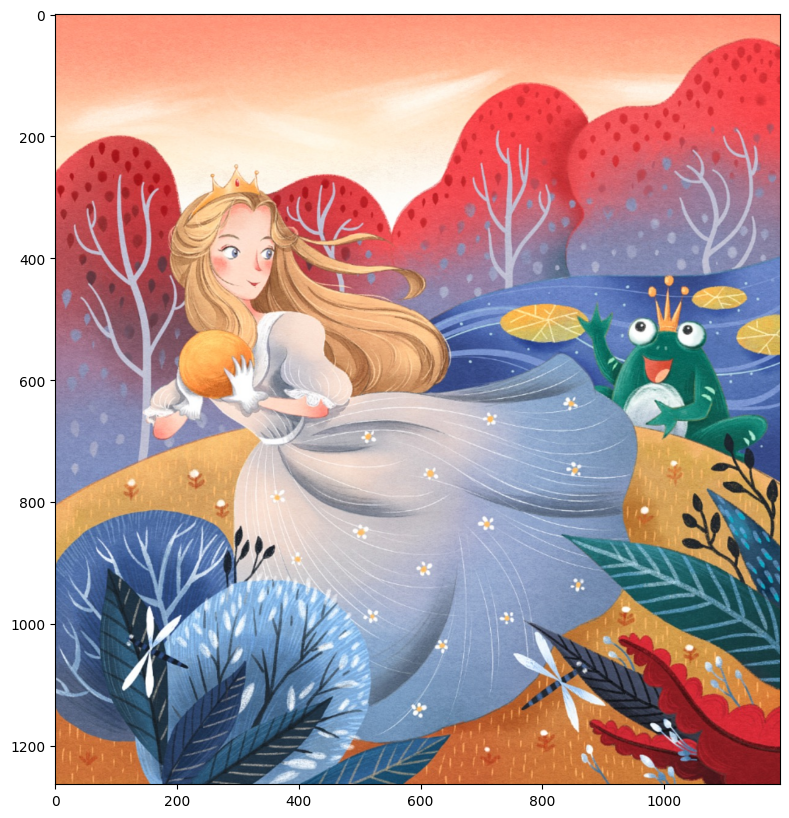

In [4]:
img = cv2.imread("images/fairytale.jpg")
vis_img = img.copy()[:, :, ::-1]
plt.figure(figsize=(10, 10))
plt.imshow(vis_img)
plt.show()


Resize image to match the maximal side length ``1024``.

In [5]:
masks = mask_generator.generate(img)

In [6]:
len(masks)

40

In [9]:
masks[1]['sem_token'].shape

(256,)

In [ ]:
text_contents = [v.flatten()[0] for v in (ious, captions)]
vis_text = "{:.2f}: {}".format(*text_contents)
plt.figure(figsize=(10,10))
plt.imshow(vis_img)
plt.figtext(0.5, 0.1, vis_text, fontsize=16, ha="center")
show_mask(masks[1], plt.gca())
plt.axis('off')
plt.show()

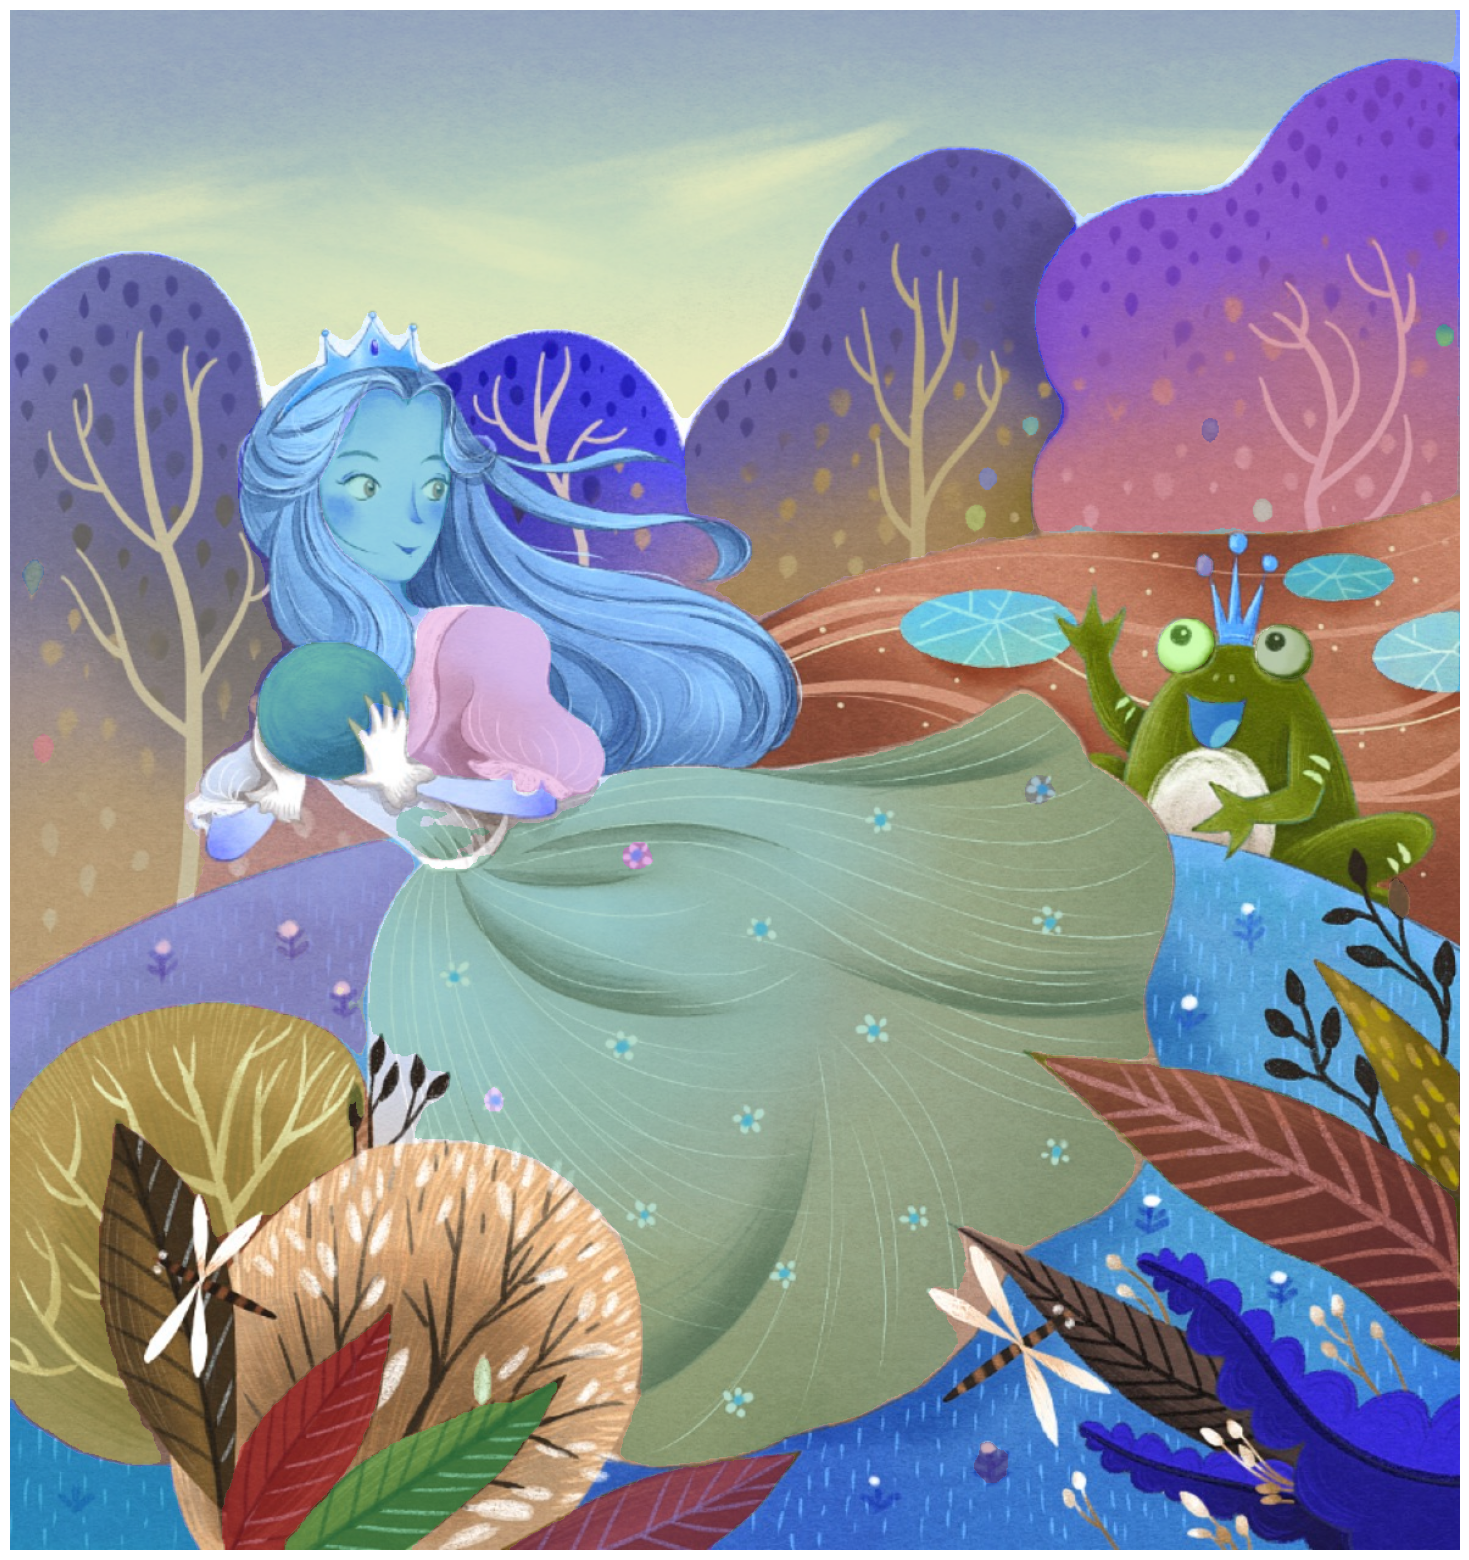

In [10]:
plt.figure(figsize=(20,20))
plt.imshow(img)
show_anns(masks)
plt.axis('off')
plt.show() 

In [5]:
# import cv2
# img = cv2.cvtColor(cv2.imread('images/fairytale.jpg'),cv2.COLOR_BGR2RGB)
tap_predictor.set_image(img)
masks, ious, _, captions = tap_predictor.predict(np.array([[[1050, 600, 1], [0, 0, 4]],
                                                          [[900, 500, 1], [0, 0, 4]]], "float32"))

In [6]:
captions

array(['green frog on the frog on the frog on the frog on the frog on the frog on the frog on the frog on the frog on the frog on the frog on the frog on the frog on the frog on the frog on the frog on the frog on the frog on the frog on the frog on the frog on the frog on the frog on the frog on the f',
       'green dinosaic tiger on the green dinosaic tiger on the green dinosaic tiger on the green dinosaic tiger on the green dinosaic tiger on the green dinosaic tiger on the green dinosaic tiger on the green dinosaic tiger on the green dinosaic tiger on the green dinosaic tiger on the green dinosaic tiger on the green dinosaic tiger on the green din'],
      dtype='<U345')

In [8]:
masks.shape

(2, 1, 1264, 1190)

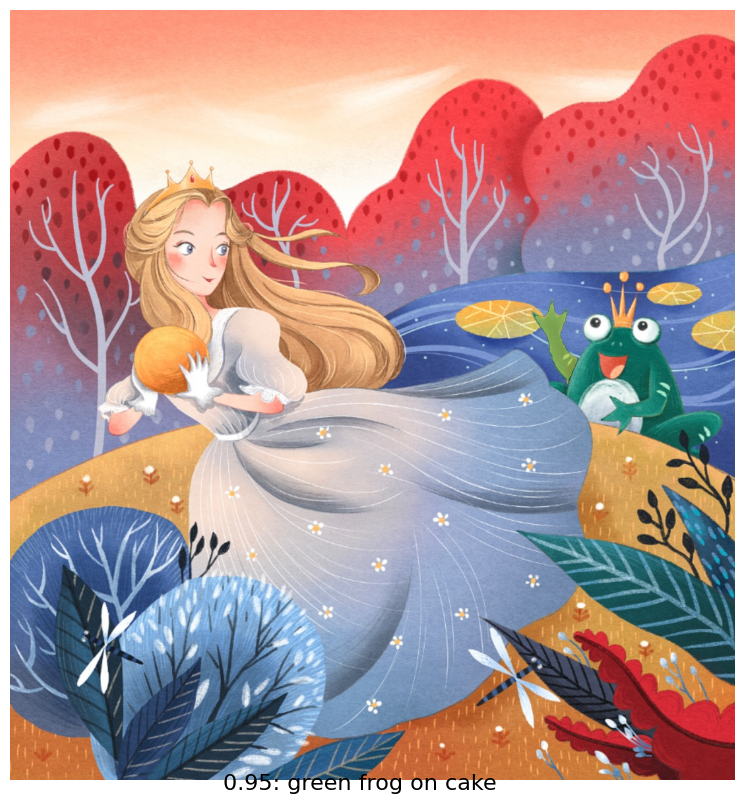

In [9]:
text_contents = [v.flatten()[0] for v in (ious, captions)]
vis_text = "{:.2f}: {}".format(*text_contents)
plt.figure(figsize=(10,10))
plt.imshow(vis_img)
plt.figtext(0.5, 0.1, vis_text, fontsize=16, ha="center")
show_mask(masks[1], plt.gca())
plt.axis('off')
plt.show()

In [8]:
import torch.nn.functional as F
q = torch.rand((2, 1, 8, 64))
k = torch.rand((2, 3, 8, 64))
v = torch.rand((2, 3, 8, 64))
attn_mask = torch.rand((1, 1, 3))
dropout_p = 0
F.scaled_dot_product_attention(q.transpose(1, 2),
                                  k.transpose(1, 2),
                                  v.transpose(1, 2),
                                  dropout_p=dropout_p,
                                   attn_mask=attn_mask).transpose(1, 2)

tensor([[[[0.6545, 0.4676, 0.3363,  ..., 0.3811, 0.4172, 0.1701],
          [0.4573, 0.4944, 0.5498,  ..., 0.4580, 0.7677, 0.2918],
          [0.5947, 0.5961, 0.4825,  ..., 0.5575, 0.5614, 0.5184],
          ...,
          [0.4977, 0.3736, 0.2011,  ..., 0.9426, 0.5107, 0.4542],
          [0.1349, 0.5616, 0.6240,  ..., 0.5385, 0.3448, 0.6746],
          [0.3341, 0.5379, 0.4746,  ..., 0.3808, 0.7212, 0.5782]]],


        [[[0.4542, 0.2070, 0.6851,  ..., 0.4592, 0.6716, 0.7059],
          [0.8056, 0.5724, 0.7525,  ..., 0.8216, 0.5264, 0.3614],
          [0.6845, 0.9020, 0.8097,  ..., 0.4185, 0.3456, 0.5304],
          ...,
          [0.4277, 0.3297, 0.7643,  ..., 0.4101, 0.7331, 0.4011],
          [0.7190, 0.4389, 0.6873,  ..., 0.1880, 0.5684, 0.3749],
          [0.1654, 0.5008, 0.2155,  ..., 0.1700, 0.5639, 0.6963]]]])

In [4]:
from tokenize_anything.utils.image import im_rescale

img_list, img_scales = im_rescale(img, scales=[1024], max_size=1024)
input_size, original_size = (1024, 1024, 3), img.shape[:2]
# print(input_size, "<-", original_size, "*", img_scales[0])
print(input_size, "<-", original_size)


(1024, 1024, 3) <- (1264, 1190)


## Visual Encoding

Stack and pad image into a batch tensor of size ``(1, 1024, 1024, 3)`` to compute ``img_embeds``. 

In [5]:
from tokenize_anything.utils.image import im_vstack
import torch
img_batch = im_vstack(img_list, fill_value=model.pixel_mean_value, size=(1024, 1024))
img = cv2.resize(img, (1024, 1024))
img_batch = torch.from_numpy(img)[None]
inputs = model.get_inputs({"img": img_batch})
inputs.update(model.get_features(inputs))


## Visual Prompt Decoding: Point

In [6]:
inputs.keys()

dict_keys(['img', 'features', 'img_embeds'])

In [8]:
inputs['img'].shape, inputs['img_embeds'].shape

(torch.Size([1, 3, 1024, 1024]), torch.Size([1, 1, 64, 64, 256]))

In [9]:
inputs["points"] = np.array([[[1050, 600, 1], [0, 0, 4]]], "float32")
# inputs["points"][:, :, :2] *= np.array(img_scales, "float32")
scale_w = 1024 / original_size[1]
scale_h = 1024 / original_size[0]
inputs["points"][:, :, 0] *= scale_w
inputs["points"][:, :, 1] *= scale_h

# Decode outputs for the point prompt.
outputs = model.get_outputs(inputs)

# Select final mask.
iou_score, mask_pred = outputs["iou_pred"], outputs["mask_pred"]
iou_score[:, 0] -= 1000.0  # Penalize the score of boundary boxes.
mask_index = torch.arange(iou_score.shape[0]), iou_score.argmax(1)
iou_scores, masks = iou_score[mask_index], mask_pred[mask_index]

In [11]:
masks.shape

torch.Size([1, 256, 256])

In [12]:
iou_scores.shape

torch.Size([1])

In [20]:
mask_index = torch.arange(iou_score.shape[0]), iou_score.argmax(1)
mask_index

(tensor([0]), tensor([2], device='cuda:0'))

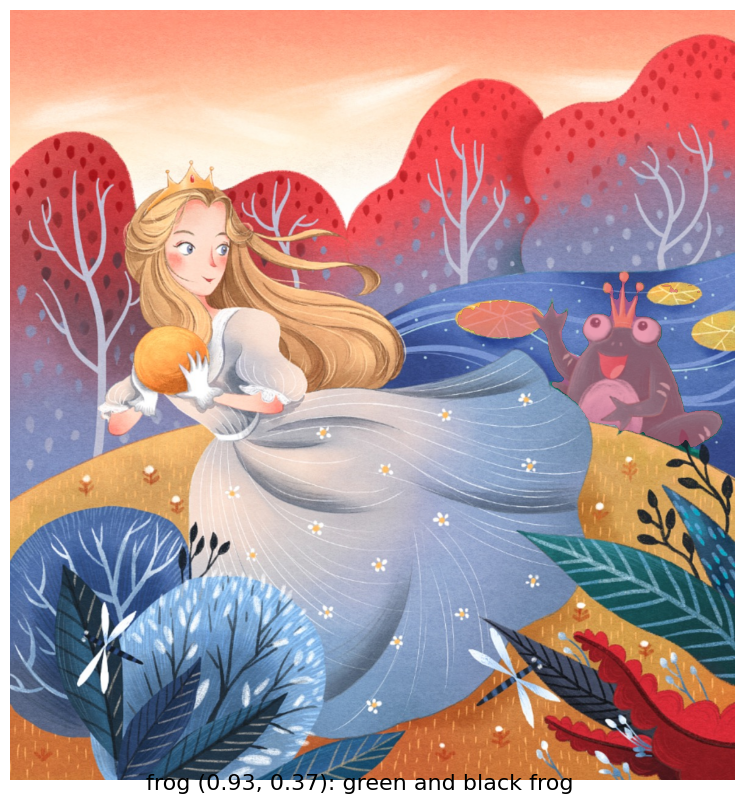

In [24]:
inputs["points"] = np.array([[[1050, 600, 1], [0, 0, 4]]], "float32")
# inputs["points"][:, :, :2] *= np.array(img_scales, "float32")
scale_w = 1024 / original_size[1]
scale_h = 1024 / original_size[0]
inputs["points"][:, :, 0] *= scale_w
inputs["points"][:, :, 1] *= scale_h

# Decode outputs for the point prompt.
outputs = model.get_outputs(inputs)

# Select final mask.
iou_score, mask_pred = outputs["iou_pred"], outputs["mask_pred"]
iou_score[:, 0] -= 1000.0  # Penalize the score of boundary boxes.
mask_index = torch.arange(iou_score.shape[0]), iou_score.argmax(1)
# mask_index = torch.arange(iou_score.shape[0]), 3
# mask_index = 1

# Upscale masks to the original image resolution.
iou_scores, masks = iou_score[mask_index], mask_pred[mask_index]
masks = model.upscale_masks(masks[:, None], img_batch.shape[1:-1])
masks = masks[..., : input_size[0], : input_size[1]]
masks = model.upscale_masks(masks, original_size).gt(0).cpu().numpy()

# Predict concepts and generate captions.
sem_tokens, sem_embeds = outputs["sem_tokens"], outputs["sem_embeds"]
concepts, scores = model.predict_concept(sem_embeds[mask_index])
captions = model.generate_text(sem_tokens[mask_index][:, None, :])

# Display comprehensive visual understanding.
text_contents = [v.flatten()[0] for v in (concepts, iou_scores, scores, captions)]
vis_text = "{} ({:.2f}, {:.2f}): {}".format(*text_contents)
plt.figure(figsize=(10,10))
plt.imshow(vis_img)
plt.figtext(0.5, 0.1, vis_text, fontsize=16, ha="center")
show_mask(masks, plt.gca())
plt.axis('off')
plt.show()


## Visual Prompt Decoding: Box

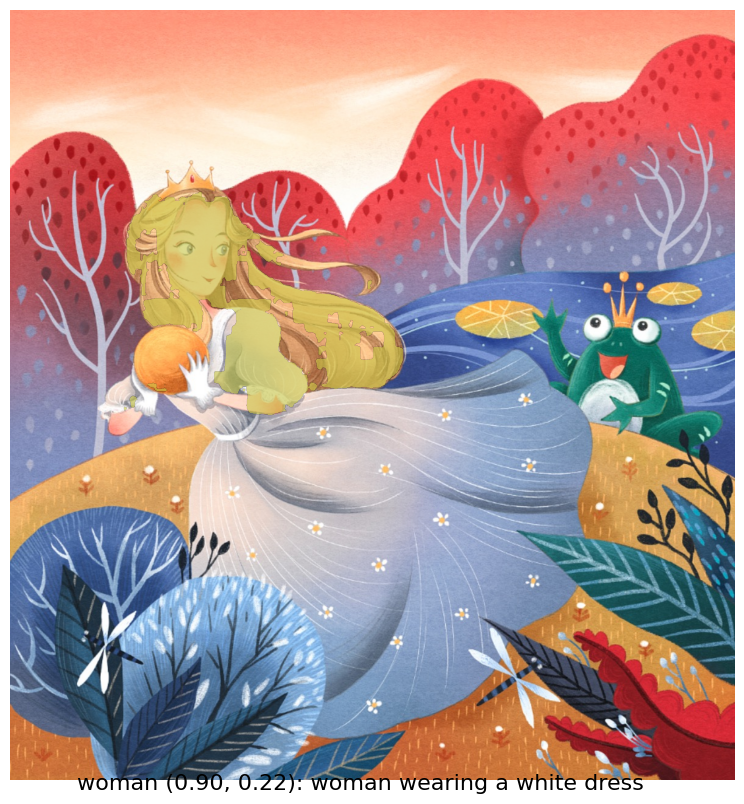

In [13]:
inputs["points"] = np.array([[[163, 237, 2], [682, 722, 3]]], "float32")
# inputs["points"][:, :, :2] *= np.array(img_scales, "float32")
inputs["points"][:, :, 0] *= scale_w
inputs["points"][:, :, 1] *= scale_h

# Decode outputs for the box prompt.
outputs = model.get_outputs(inputs)

# Select final mask.
iou_score, mask_pred = outputs["iou_pred"], outputs["mask_pred"]
iou_score[:, 1:] -= 1000.0  # Penalize the score of loose points.
mask_index = torch.arange(iou_score.shape[0]), iou_score.argmax(1)

# Upscale masks to the original image resolution.
iou_scores, masks = iou_score[mask_index], mask_pred[mask_index]
masks = model.upscale_masks(masks[:, None], img_batch.shape[1:-1])
masks = masks[..., : input_size[0], : input_size[1]]
masks = model.upscale_masks(masks, original_size).gt(0).cpu().numpy()

# Predict concepts and generate captions.
sem_tokens, sem_embeds = outputs["sem_tokens"], outputs["sem_embeds"]
concepts, scores = model.predict_concept(sem_embeds[mask_index])
captions = model.generate_text(sem_tokens[mask_index][:, None, :])

# Display comprehensive visual understanding.
text_contents = [v.flatten()[0] for v in (concepts, iou_scores, scores, captions)]
vis_text = "{} ({:.2f}, {:.2f}): {}".format(*text_contents)
plt.figure(figsize=(10,10))
plt.imshow(vis_img)
plt.figtext(0.5, 0.1, vis_text, fontsize=16, ha="center")
show_mask(masks, plt.gca())
plt.axis('off')
plt.show()


## Visual Prompt Decoding: Sketch

In [11]:
inputs["points"] = np.array([[
    [255, 337, 1], [295, 435, 1], [411, 598, 1], [415, 782, 1],
    [494, 937, 1], [702, 1090, 1], [812, 906, 1], [849, 748, 1], 
    [783, 627, 1], [0, 0, 4],
]], "float32")
inputs["points"][:, :, :2] *= np.array(img_scales, "float32")

# Decode outputs for the sketch prompt.
outputs = model.get_outputs(inputs)

# Select final mask.
iou_score, mask_pred = outputs["iou_pred"], outputs["mask_pred"]
iou_score[:, 0] -= 1000.0  # Penalize the score of boundary boxes.
mask_index = torch.arange(iou_score.shape[0]), iou_score.argmax(1)

# Upscale masks to the original image resolution.
iou_scores, masks = iou_score[mask_index], mask_pred[mask_index]
masks = model.upscale_masks(masks[:, None], img_batch.shape[1:-1])
masks = masks[..., : input_size[0], : input_size[1]]
masks = model.upscale_masks(masks, original_size).gt(0).cpu().numpy()

# Predict concepts and generate captions.
sem_tokens, sem_embeds = outputs["sem_tokens"], outputs["sem_embeds"]
concepts, scores = model.predict_concept(sem_embeds[mask_index])
captions = model.generate_text(sem_tokens[mask_index][:, None, :])

# Display comprehensive visual understanding.
text_contents = [v.flatten()[0] for v in (concepts, iou_scores, scores, captions)]
vis_text = "{} ({:.2f}, {:.2f}): {}".format(*text_contents)
plt.figure(figsize=(10,10))
plt.imshow(vis_img)
plt.figtext(0.5, 0.1, vis_text, fontsize=16, ha="center")
show_mask(masks, plt.gca())
plt.axis('off')
plt.show()


NameError: name 'img_scales' is not defined